In [1]:
from helpers import *

In [2]:
# Load datasets
df_articles, df_clicks, article_embeddings = load_dataset()

In [3]:
print("df_articles", df_articles.shape)
print("df_clicks", df_clicks.shape)
print("article_embeddings", article_embeddings.shape)

# df_clicks = df_clicks.sample(n=50000).reset_index()
# article_embeddings = article_embeddings[:70000]

print("----", df_articles.shape)
print("df_articles", df_articles.shape)
print("df_clicks", df_clicks.shape)
print("article_embeddings", article_embeddings.shape)

df_articles (364047, 5)
df_clicks (2988181, 12)
article_embeddings (364047, 250)
---- (364047, 5)
df_articles (364047, 5)
df_clicks (2988181, 12)
article_embeddings (364047, 250)


In [4]:
# cosine_similarities  = cosine_similarity(article_embeddings)
# cosine_similarities.shape

## Preparing the data

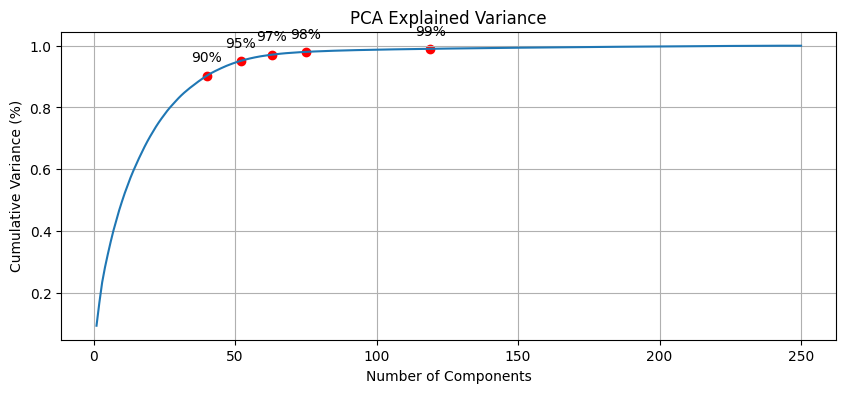

In [5]:
pca = PCA()
pca.fit(article_embeddings)

# Variance data
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
components = np.arange(len(cumulative_variance)) + 1

# Plotting
plt.figure(figsize=(10,4))
plt.plot(components, cumulative_variance, label='Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('PCA Explained Variance')

# Annotate specific variance percentages
variance_thresholds = [0.9, 0.95, 0.97, 0.98, 0.99]
for threshold in variance_thresholds:
    component_number = np.where(cumulative_variance >= threshold)[0][0]
    plt.scatter(component_number + 1, cumulative_variance[component_number], color='red')
    plt.annotate(f"{int(threshold*100)}%", (component_number + 1, cumulative_variance[component_number]),
                 textcoords="offset points", xytext=(0,10), ha='center')

plt.grid(True)
plt.show()
 

In [6]:

pca = PCA(n_components=0.2)
reduced_embeddings = pca.fit_transform(article_embeddings)
print(reduced_embeddings.shape)
reduced_embeddings = article_embeddings
# cosine_sim_old = cosine_similarity(reduced_embeddings)


(364047, 3)


In [7]:
# sparse_matrix = csr_matrix(reduced_embeddings)

In [8]:
# # File path for saved results
# cosine_sim_file = 'cosine_similarity_matrix.pkl'

# # Compute cosine similarity in chunks with progress update and save
# def chunked_cosine_similarity(matrix, chunk_size=20000):
#     row_count = matrix.shape[0]
#     result = np.zeros((row_count, row_count))
    
#     for start in range(0, row_count, chunk_size):
#         end = min(start + chunk_size, row_count)
#         sim_chunk = cosine_similarity(matrix[start:end], matrix)
#         result[start:end, :] = sim_chunk
        
#         # Progress update
#         progress = 100 * end / row_count
#         print(f"Progress: {progress:.2f}% complete")
    
#     # Save result to file using pickle
#     with open(cosine_sim_file, 'wb') as f:
#         pickle.dump(result, f)
        
#     return result

# # If the file exists, load it; otherwise, compute and save.
# if os.path.exists(cosine_sim_file):
#     with open(cosine_sim_file, 'rb') as f:
#         cosine_sim = pickle.load(f)
#     print("Loaded cosine similarity from file.")
# else:
#     cosine_sim = chunked_cosine_similarity(sparse_matrix)
#     print("Computed cosine similarity and saved to file.")

In [9]:
# Merge clicks with article metadata
df_merged = pd.merge(df_clicks, df_articles, how='left', left_on='click_article_id', right_on='article_id')
df_merged['session_start'] = pd.to_datetime(df_merged['session_start'])
df_merged.sort_values('session_start', inplace=True)

In [10]:
df_merged['user_id'] = df_merged['user_id'].astype('category')
df_merged['click_article_id'] = df_merged['click_article_id'].astype('category')

In [11]:
# Splitting data into train and test sets (e.g., last 20% of sessions as test)
split_idx = int(len(df_merged) * 0.8)
train_data = df_merged.iloc[:split_idx]
test_data = df_merged.iloc[split_idx:]

## Collaborative Filtering Model

### Build & train model

In [12]:
# Load the dataset in Surprise's format
reader = Reader(rating_scale=(1, 10)) # Assuming clicks can imply a rating from 1 to 10 (to be adjusted)
data = Dataset.load_from_df(train_data[['user_id', 'click_article_id', 'session_size']], reader)

# Splitting the dataset for evaluation
trainset, testset = train_test_split_surprise(data, test_size=0.2)

# Use SVD (Singular Value Decomposition)
model = SVD()
model.fit(trainset)

### Evaluate model

In [13]:
# Predictions
predictions = model.test(testset)

# Compute RMSE (Root Mean Square Error)
accuracy.rmse(predictions)

RMSE: 2.8775


2.87751259478205

## Content-Based Model

### Build & Train Model

In [17]:
df_clicks

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162
...,...,...,...,...,...
364042,364042,460,1434034118000,0,144
364043,364043,460,1434148472000,0,463
364044,364044,460,1457974279000,0,177
364045,364045,460,1515964737000,0,126


In [26]:
articles_metadata

,click_article_id,article_id,category_id,created_at_ts,publisher_id,words_count
0,160974,160974,281,1506912747000,0,259
1,272143,272143,399,1506961870000,0,184
2,336221,336221,437,1507613161000,0,158
3,234698,234698,375,1507618597000,0,183
4,123909,123909,250,1507198955000,0,240
...,...,...,...,...,...,...
46028,283269,283269,412,1490359834000,0,157
46029,329065,329065,436,1406370513000,0,248
46030,38473,38473,51,1304425027000,0,232
46031,289316,289316,421,1503058025000,0,162


In [52]:
articles

Index([160974, 272143, 336221, 234698, 123909, 336223,  96210, 162655, 183176,
       168623,
       ...
       227165, 109189, 185677, 185759, 280037, 283269, 329065,  38473, 289316,
       164517],
      dtype='object', name='click_article_id', length=46033)

In [58]:
articles = df_clicks.click_article_id.value_counts().index
df_articles_resized = df_articles.loc[articles].reset_index()
article_embeddings_resized = article_embeddings[list(map(int, articles))]

In [60]:
article_embeddings_resized.shape

(46033, 250)

In [59]:
# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(article_embeddings_resized)

# Ensuring the diagonal elements are zero (no self similarity considered)
np.fill_diagonal(cosine_sim, 0)

In [64]:
def get_recommendations(article_id, cosine_sim=cosine_sim, top_n=5):
    # Get the article index corresponding to original article_id
    idx = np.where(df_articles_resized['article_id'] == article_id)[0][0]
    
    # Get the pairwsie similarity scores of all articles with that article
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the articles based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top-n most similar articles
    sim_scores = sim_scores[:top_n]
    
    # Get the article indices
    article_indices = [i[0] for i in sim_scores]
    
    # Return the top-n most similar articles
    return df_articles_resized['article_id'].iloc[article_indices]

### Evaluate Model

In [65]:
def precision_at_k(recommended_articles, actual_articles, k=5):
    # Calculate how many recommended articles are in the actual articles
    act_set = set(actual_articles)
    pred_set = set(recommended_articles[:k])
    result = len(act_set & pred_set) / float(k)
    return result

# Function to get actual clicked articles in the test data for a user
def get_actual_articles(user_id, test_data):
    actual_articles = test_data[test_data['user_id']==user_id]['click_article_id'].tolist()
    return actual_articles

In [66]:
# Evaluate the model for a sample user
sample_user_id = test_data['user_id'].iloc[10]
actual_articles = get_actual_articles(sample_user_id, test_data)
recommended_articles = get_recommendations(test_data[test_data['user_id']==sample_user_id]['click_article_id'].iloc[0])

precision_score = precision_at_k(recommended_articles, actual_articles)
print("Precision@5:", precision_score)

Precision@5: 0.0


In [67]:
recommended_articles

913      286077
42141    284034
3008     283116
30757    100792
17530    286071
Name: article_id, dtype: int64